## ARIMA and Family👨‍👨‍👦

So far we have discussed upto ARIMA models, Now time to add **S** into the model, which stands for Seasonality.

<img src='../Images/SARIMA and family.png'>

### Breafing about time series modeling using ARIMA

## $ARIMA$

Decompose the word ARIMA => AR ~ *i* ~ MA

- AR(p)
    - AR stands fore Autoregressive. In other word our time series coorelated with it's past values. Hence, we can predict the future based on some combination of past values. The term *p* defined the order of AR model.The order of an autoregression is the number of immediately preceding values in the series that are used to predict the value at the present time.


with term *p* we can define our series(y) using following equation.

$y_{t}$ = *k* + $w_{1}$*$y_{t-1}$ + $w_{2}$*$y_{t-2}$ + .... + $w_{p}$ $y_{t-p}$ + $\epsilon_{t}$ ; *where* $w_{i}$ *is the weights of past values and* $\epsilon_{t}$ *is white noice*

Easiest way to determine order of AR model is, plotting PACF plot and find the last significant lag q.

- MA(q)
    - To determining order of MA model, first we need to indentyfy correlation of time series with it's past values. To do that we can use ACF plots.IN ACF plot, if we see significant coefficients, then we must check if they become abruptly non-significant after some lag q. If that is the case, then we know that we have a moving average process of order q. Otherwise, we must follow a different set of steps to discover the underlying process of our time series.

- i(d)
    - This indicates the level of deferencing requred to make non-stationary time series into a stationary time series.

Together all we have ARIMA(p,d,q) model.Now problem is how do we figure out these p,d and q terms.

In [396]:
import json
import warnings
import holidays 
import pandas as pd 
from tqdm import tqdm
from datetime import date
from itertools import product
import matplotlib.pyplot as plt 
from urllib.request import urlopen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_percentage_error as MAPE 

warnings.filterwarnings('ignore')
PC = '#FF3B2B'

In [78]:
data = pd.read_csv("../Datasets\wiki_views_2010010100_2022043000.csv",index_col=[0],nrows=1100)
data.index = pd.DatetimeIndex(data.index)
test = data.iloc[1000:]
data = data.iloc[0:1000]

In [79]:
data.head()

,views
2015-07-01,264.542787
2015-07-02,270.340050
2015-07-03,253.265588
2015-07-04,253.088829
2015-07-05,266.057125


In [80]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y,color='black',alpha=0.6)
        p_value = adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value),
            fontsize=17,fontweight='semibold',fontfamily='serif'
        )
        plot_acf(y, lags=lags, ax=acf_ax,color=PC)
        plot_pacf(y, lags=lags, ax=pacf_ax,color=PC)
        plt.tight_layout()

Let's plot our initial time series first.

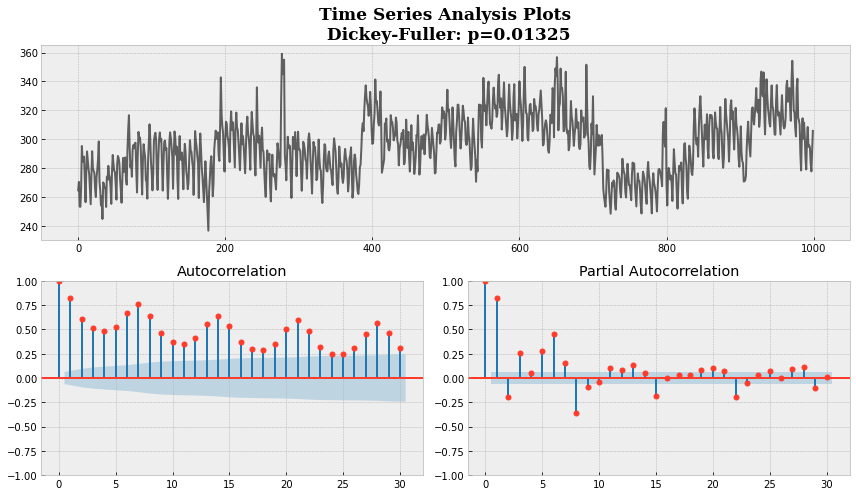

In [81]:
tsplot(data.views.values)

As we can see in above it has heavy seasonality and trend. It confirms also in ADFTest resuls as well.First of all we should get rid of that seasonality. If you clearly look at the ACF plot, you will notice that time series highly correlated with 7 day lag. Let's remove it. We can easly do this using pandas method called .diff(). Instead we are going to use pandas.shift() method. All we have to do is remove its 7 day lag from original data.

In [82]:
data_diff = data - data.shift(7)

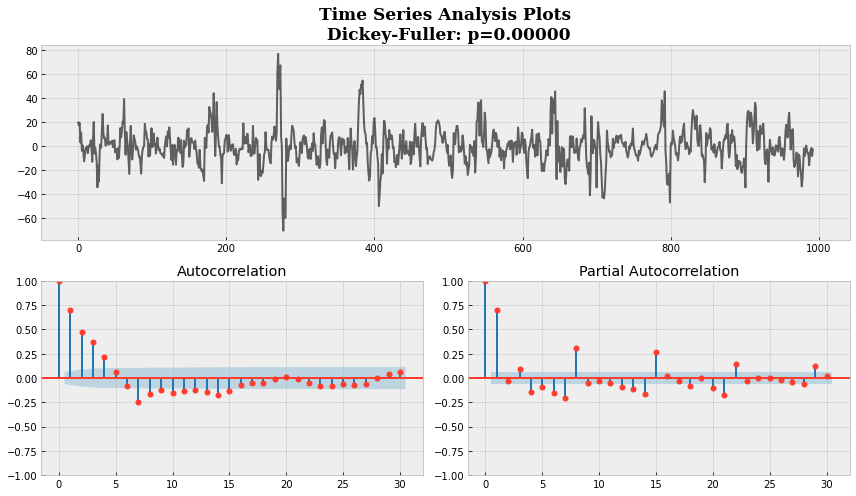

In [83]:
tsplot(data_diff[7:].views.values)

Using that mechanisam we reduced the seasonality of time series. As per the ADFTest we can confirm that. But if you notice in ACF plot, still there is high correlation with 1 day lag.

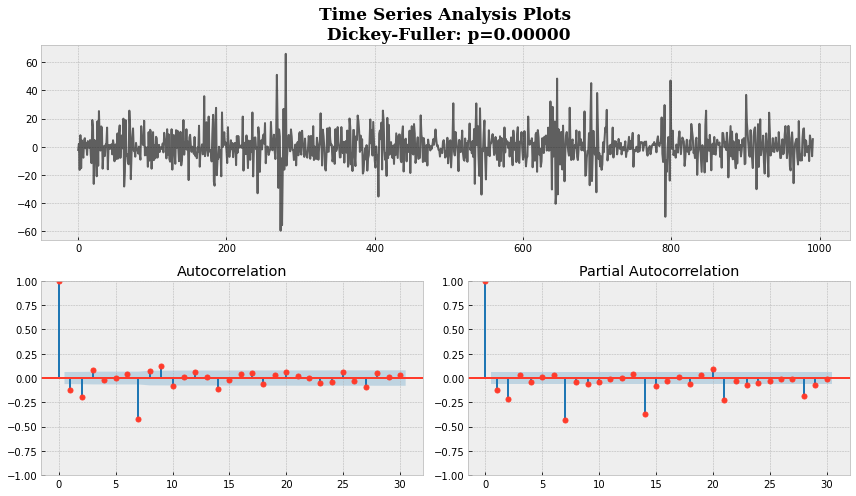

In [84]:
data_diff = data_diff - data_diff.shift(1)
tsplot(data_diff[7+1:].views.values)

Now its almost gone. But we can notice still there is significance lag with day 2 lag. But we will stop here.

 $p$ is most probably 7. Because it has the most significant lag among top order lags.

 $d$ equals 1 because we had first differences

 $q$ should be somewhere around 7 as well as seen on the ACF

Lets derive this info using some standra method.

In [85]:
p = range(3, 10)
d = 1
q = range(3, 10)

# creating list with all the possible combinations of parameters
parameters = product(p, q)
parameters_list = list(parameters)
len(parameters_list),parameters_list[0]

(49, (3, 3))

In [86]:
def optimizeARIMA(parameters_list, d):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = SARIMAX(
                data.views,
                order=(param[0], d, param[1]),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table,best_model

In [87]:
def plot_predictions(observed,predicted):

    error = "{0:.3f}%".format(MAPE(observed,predicted)*100)

    plt.figure(figsize=(15,7))
    plt.plot(observed,color='black',label='oberved')
    plt.plot(predicted,color='#FF3B2B',label='predicted')
    plt.legend(loc='upper center')
    plt.xlabel("Date",fontfamily='serif')
    plt.ylabel("Views (Mn)",fontfamily='serif')
    plt.title(f"Predictions vs Observed\nMAPE={error}", fontsize=18,fontweight='semibold',fontfamily='serif')
    plt.grid(True)
    plt.show()

In [13]:
result_table,sarima_model = optimizeARIMA(parameters_list, d)

100%|██████████| 49/49 [01:58<00:00,  2.42s/it]


In [14]:
result_table.head()

,parameters,aic
0,"(9, 9)",7105.032600
1,"(9, 7)",7109.345484
2,"(7, 9)",7111.122103
3,"(9, 8)",7120.032856
4,"(8, 9)",7121.220907


In [15]:
resid = sarima_model.resid
resid = resid[7+1:].values

Lets plot model residuals. Using this method we can make sure whether our model has captured the all possible signals or not. Hence,
1. Resuduals should not show any correlation with its past values.
2. It should dustributed with mean 0

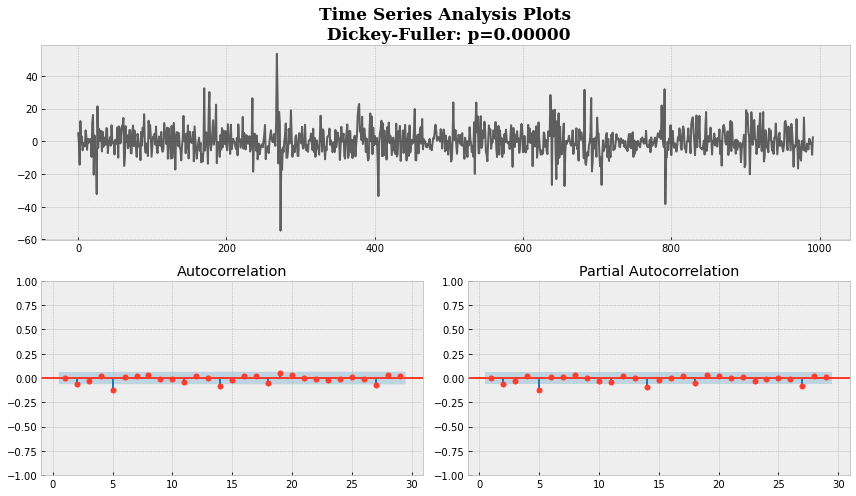

In [16]:
tsplot(resid,lags=range(1,30))

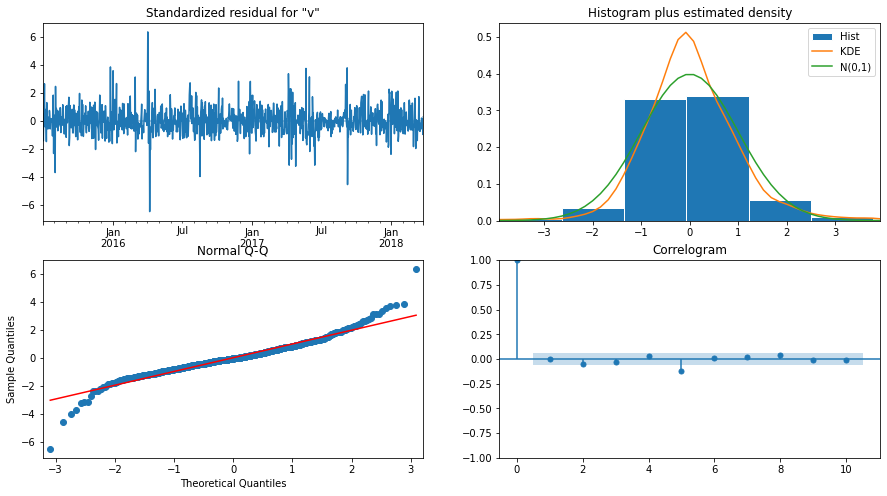

In [17]:
ax= sarima_model.plot_diagnostics(figsize=(15,8))
plt.show()

Let's make some future forecasts

In [18]:
future_predictions = sarima_model.predict(start=data.shape[0], end=data.shape[0] + 99)

In [19]:
data.tail()

,views
2018-03-22,294.156473
2018-03-23,283.407906
2018-03-24,277.636125
2018-03-25,290.927648
2018-03-26,305.717400


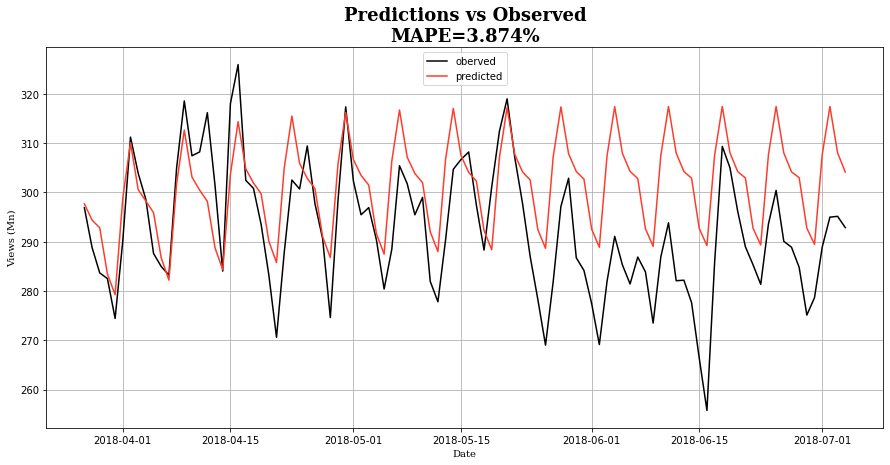

In [21]:
plot_predictions(test,future_predictions)

Cool, now we have baseline model to beat. Let's add $S$ into the model. With that we have entered the $SARIMA$ modeling. And now we have additional parameters $P$,$Q$ and $D$.

Okay, lets find the optimum parameters for SARIMA model.

## $SARIMA$

In [12]:
ps = range(5, 8)
d = 1
qs = range(6, 8)
Ps = range(6, 8)
D = 1
Qs = range(6, 8)
s = 7

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [13]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = SARIMAX(
                data.views,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table

In [14]:
result_table = optimizeSARIMA(parameters_list,d,D,s)

100%|██████████| 24/24 [05:00<00:00, 12.52s/it]


,parameters,aic
0,"(5, 6, 6, 6)",3530.137731
1,"(6, 6, 7, 6)",3530.995463
2,"(6, 6, 6, 6)",3531.710007
3,"(5, 6, 7, 7)",3532.027515
4,"(6, 6, 6, 7)",3532.218886
5,"(6, 6, 7, 7)",3533.531837


In [88]:
p, q, P, Q = (5,6,6,6)

best_model = SARIMAX(
    data.views, order=(p, d, q), seasonal_order=(P, D, Q, s)
).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                 1000
Model:             SARIMAX(5, 1, 6)x(6, 1, 6, 7)   Log Likelihood               -3500.139
Date:                           Mon, 02 May 2022   AIC                           7048.277
Time:                                   10:32:20   BIC                           7165.871
Sample:                               07-01-2015   HQIC                          7092.988
                                    - 03-26-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0924      0.353     -0.262      0.794      -0.784       0.600
ar.L2         -0.4210      0.300     -1.402

In [96]:
def plotSARIMA(model,train,test):
    predictions = model.get_prediction(train.shape[0],train.shape[0]+99)
    predictions_conf_int = predictions.conf_int()
    predictions = pd.DataFrame(index=test.index,data=predictions.predicted_mean.values)
    
    plt.figure(figsize=(15,7))
    plt.plot(test,color='black',label='oberved')
    plt.plot(predictions,color='#FF3B2B',label='predicted')
    plt.fill_between(predictions.index,
                    predictions_conf_int.iloc[:, 0],
                    predictions_conf_int.iloc[:, 1], color='g', alpha=0.3)
    plt.legend(loc='upper center')
    plt.xlabel("Date",fontfamily='serif')
    plt.ylabel("Views (Mn)",fontfamily='serif')
    plt.title(f"Predictions vs Observed\n MAPE:{MAPE(test,predictions)*100:.3f}%", fontsize=18,fontweight='semibold',fontfamily='serif')
    plt.grid(True)
    plt.show()

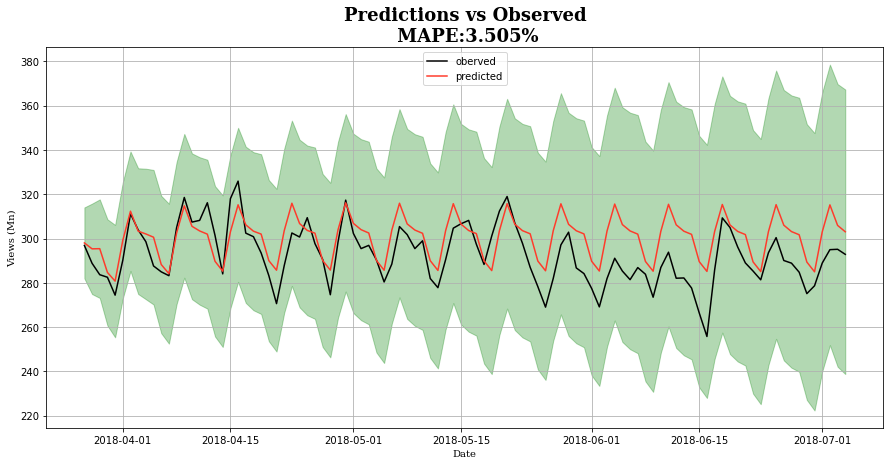

In [97]:
plotSARIMA(best_model,data,test)

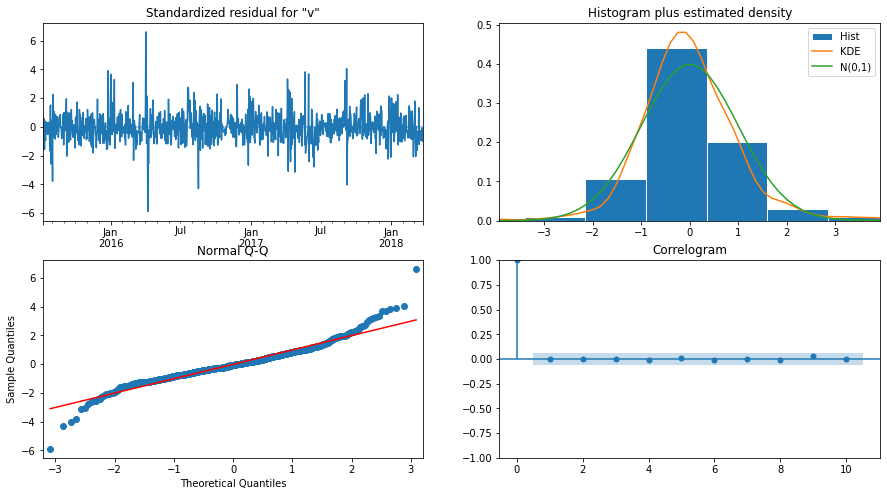

In [92]:
ax= best_model.plot_diagnostics(figsize=(15,8))
plt.show()

In [98]:
p, q, P, Q = (5,6,6,6)

best_model = SARIMAX(
    data.views, 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                 1000
Model:             SARIMAX(5, 1, 6)x(6, 1, 6, 7)   Log Likelihood               -3320.862
Date:                           Mon, 02 May 2022   AIC                           6689.724
Time:                                   10:43:13   BIC                           6806.102
Sample:                               07-01-2015   HQIC                          6734.081
                                    - 03-26-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0589      0.198     -0.297      0.766      -0.447       0.329
ar.L2         -0.2617      0.191     -1.372

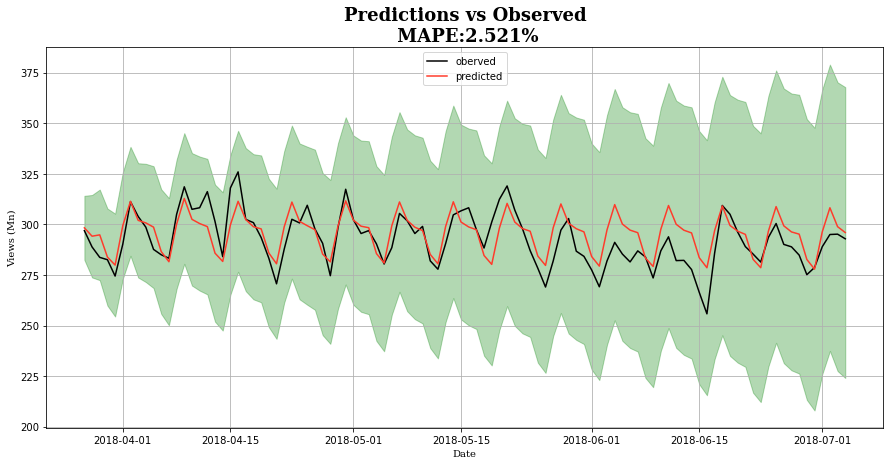

In [99]:
plotSARIMA(best_model,data,test)

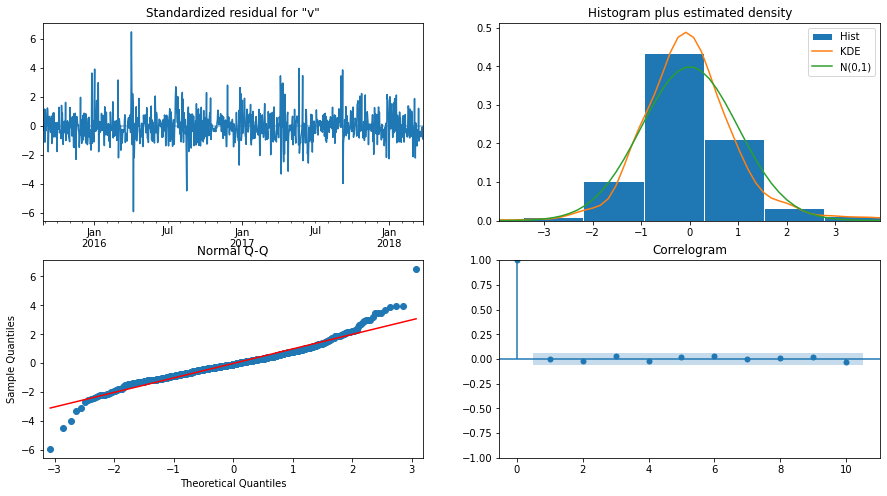

In [100]:
ax= best_model.plot_diagnostics(figsize=(15,8))
plt.show()

Let's add $X$ term to $SARIMA$ model. We can use any variable as $X$, but is should be somehow correlated with original series.

## $SARIMAX$

Before doing anything, first we have to look at appropriate $X$ varible. Since this dataset is about page views, the holyday and weekend varibles would be sutaible. Let's add them. To get holyday informations I'm going to extract holydays of top wikipedia using countries.

In [397]:
data.index.min()

Timestamp('2015-07-01 00:00:00')

In [398]:
with urlopen("https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/all-projects/all-access/2015/07") as resp:
    content = json.loads(resp.read())
top_countries = pd.DataFrame(content['items'][0]['countries']).head(20)
top_countries

,country,views,rank,views_ceil
0,US,1000000000-9999999999,1,4113821000
1,JP,1000000000-9999999999,2,1240222000
2,DE,1000000000-9999999999,3,1030194000
3,GB,100000000-999999999,4,787245000
4,RU,100000000-999999999,5,615281000
5,FR,100000000-999999999,6,597015000
6,IT,100000000-999999999,7,500709000
7,IN,100000000-999999999,8,491424000
8,CA,100000000-999999999,9,394810000
9,BR,100000000-999999999,10,302334000


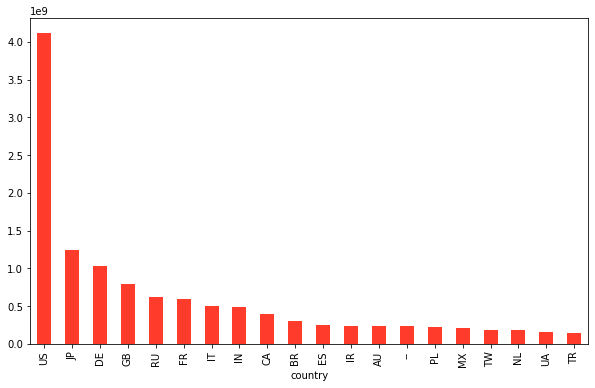

In [399]:
plt.figure(figsize=(10,6))
ax = top_countries.set_index('country').views_ceil.plot.bar(color=PC)
plt.show()

In [400]:
top_countries['ratio'] = top_countries.views_ceil/top_countries.views_ceil.sum()
top_countries.head()

,country,views,rank,views_ceil,ratio
0,US,1000000000-9999999999,1,4113821000,0.338947
1,JP,1000000000-9999999999,2,1240222000,0.102185
2,DE,1000000000-9999999999,3,1030194000,0.084880
3,GB,100000000-999999999,4,787245000,0.064863
4,RU,100000000-999999999,5,615281000,0.050694


Additionally I'm going to add weitages based on the page viewers last month.

In [401]:
weights = dict(zip(top_countries.country.values,top_countries.ratio.values))

In [402]:
def get_country_holydays(countries,start_year,end_year,weights=None):
    start_date = date(start_year,1,1)
    end_date = date(end_year,12,31)

    holidays_df = pd.DataFrame(data=pd.date_range(start_date,end_date),columns=['date'])
    for country in countries:
        try:
            h = holidays.country_holidays(country)
            holidays_df[country] = holidays_df['date'].apply(lambda x:int(x in h))
            if weights:holidays_df[country] = holidays_df[country].multiply(weights[country])
        except NotImplementedError:
            pass
    return holidays_df.set_index('date').sum(axis=1)


In [403]:
holyday_list = get_country_holydays(top_countries.country.values,2015,2018,weights=weights)

In [404]:
holyday_list.head()

date
2015-01-01    0.920319
2015-01-02    0.115557
2015-01-03    0.050694
2015-01-04    0.050694
2015-01-05    0.050694
dtype: float64

Now time to get weekend features.

In [405]:
def is_weekend(df):
    df = df.copy()
    df['weekend'] = [x.day_name() for x in df.index]
    df['weekend'] = df['weekend'].apply(lambda x:1 if x in['Saturday','Sunday'] else 0)
    return df

In [406]:
data = is_weekend(data)
test = is_weekend(test)

In [407]:
data['holyday_weight'] = holyday_list[data.index]
test['holyday_weight'] = holyday_list[test.index]

First experiment with $weekend$ feature.

In [408]:
p, q, P, Q = (5,6,6,6)

m = SARIMAX(
    endog = data.views, 
    exog= data.weekend,
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=-1)

In [409]:
forecasts = m.forecast(steps=100, exog = test['weekend'])

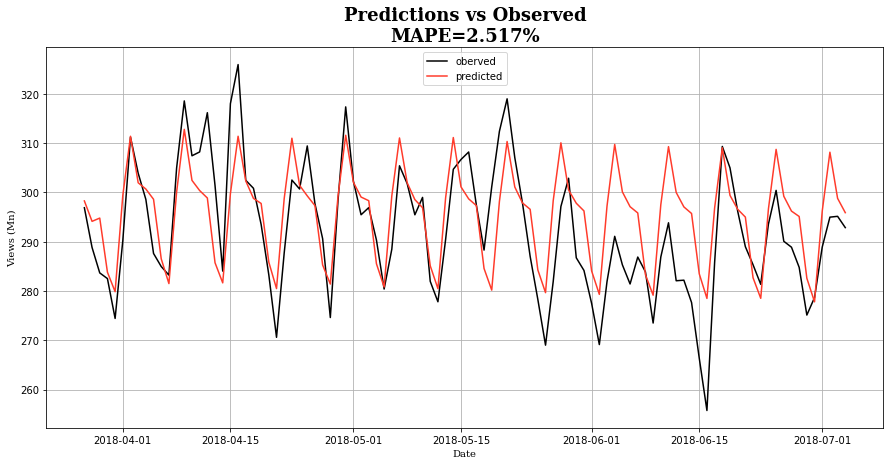

In [393]:
plot_predictions(test['views'],forecasts)

Now time to experiment with $Holyday$ feature

In [410]:
p, q, P, Q = (5,6,6,6)

best_model = SARIMAX(
    endog = data.views, 
    exog= data.holyday_weight,
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=-1)

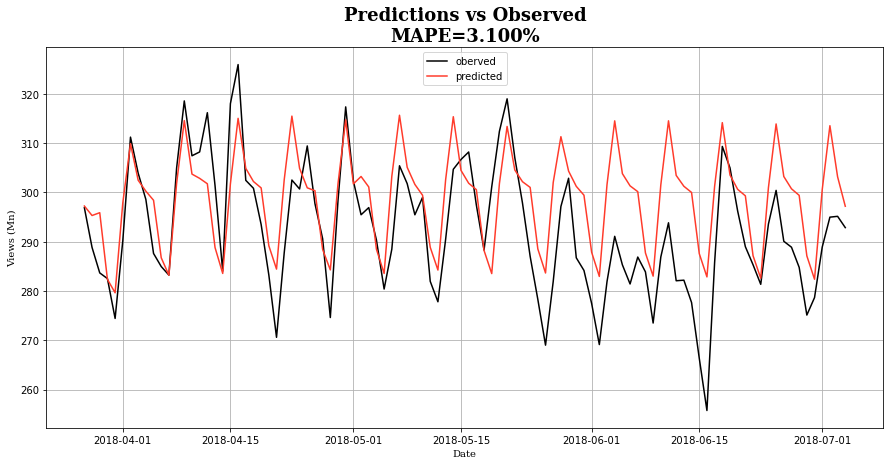

In [411]:
forecasts = best_model.forecast(steps=100, exog = test['holyday_weight'])
plot_predictions(test['views'],forecasts)